# Decision Trees and Random Forests

![](https://i.imgur.com/N8aIuRK.jpg)

In this notebook files, I performed the following tasks. 

- Explore uavsar-pits data
- Preparing the dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting, hyperparameter tuning & regularization
- Making predictions on single inputs



Import some required libraries before we begin.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

The file `uavsar_SWE_ENV.csv`contains the data. Let's load it into a Pandas dataframe.

In [2]:
raw_df = pd.read_csv('/home/naheemadebisi/PhD/snow-analytics/Radar-Backscatter/pits_data/uavsar_SWE_ENV.csv')

In [3]:
raw_df

,Unnamed: 0,Location,PitID,Density Mean (kg/m^3),Snow Depth (cm),SWE (mm),HH,HV,VH,VV,Temp_mean,Ground Condition,Ground Roughness,Ground Vegetation,Canopy
0,0,Boise River Basin,IDBRBL_20210127_1330,291.5,122.0,356.5,0.104028,0.101899,0.097273,0.116420,-3.500000,Frozen,Smooth,Bare,Sparse (5-20%)
1,1,Boise River Basin,IDBRBT_20210127_1500,292.5,69.0,202.0,0.415091,0.119713,0.097183,0.217637,NaN,Frozen,Smooth,Bare | Deadfall,Closed (>70%)
2,2,Boise River Basin,IDBRLO_20210126_1205,292.0,78.0,227.5,0.163230,0.044706,0.053978,0.143295,-2.755556,Moist,Rough,Shrub,No Trees
3,3,Boise River Basin,IDBRLT_20210126_1335,248.0,22.0,55.0,0.243080,0.121562,0.119280,0.257768,-2.000000,Moist,Rough,Deadfall,Closed (>70%)
4,4,Boise River Basin,IDBRBS_20210128_1200,252.5,141.0,355.0,0.367296,0.087664,0.057098,0.177950,-3.913333,Frozen,Smooth,Bare,Sparse (5-20%)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,281,Senator Beck,COSBSA_20210303_1305,303.0,145.0,439.0,0.228256,0.067750,0.060650,0.208844,-3.487500,Moist,Smooth,Grass,No Trees
282,282,Senator Beck,COSBSA_20210127_1210,236.0,127.0,300.0,0.156946,0.038421,0.036239,0.141845,-5.614286,Frozen,Rough,Grass,No Trees
283,283,Senator Beck,COSBSA_20210317_1241,283.0,192.0,544.5,0.149433,0.045109,0.052350,0.127968,-2.757143,Moist,Smooth,Grass,No Trees
284,284,Senator Beck,COSBSA_20210310_1322,310.5,158.0,491.0,0.217294,0.044286,0.047237,0.211791,-3.123529,Frozen,Smooth,Grass,No Trees


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             286 non-null    int64  
 1   Location               286 non-null    object 
 2   PitID                  286 non-null    object 
 3   Density Mean (kg/m^3)  286 non-null    float64
 4   Snow Depth (cm)        286 non-null    float64
 5   SWE (mm)               286 non-null    float64
 6   HH                     277 non-null    float64
 7   HV                     277 non-null    float64
 8   VH                     277 non-null    float64
 9   VV                     277 non-null    float64
 10  Temp_mean              272 non-null    float64
 11  Ground Condition       284 non-null    object 
 12  Ground Roughness       284 non-null    object 
 13  Ground Vegetation      282 non-null    object 
 14  Canopy                 285 non-null    object 
dtypes: flo

In [5]:
raw_df.isna().sum()

Unnamed: 0                0
Location                  0
PitID                     0
Density Mean (kg/m^3)     0
Snow Depth (cm)           0
SWE (mm)                  0
HH                        9
HV                        9
VH                        9
VV                        9
Temp_mean                14
Ground Condition          2
Ground Roughness          2
Ground Vegetation         4
Canopy                    1
dtype: int64

There is not a lot of missing data so we can safely drop the missing rows.

In [6]:
raw_df.dropna(inplace=True)

### Training, Validation and Test Sets

In [7]:
#train-validation-test split
train_df , test_df = train_test_split(raw_df, test_size= 0.2, random_state= 20221104)
train_df , val_df = train_test_split(train_df, test_size= 0.2, random_state= 20221105)

print(f"lenth of the training data is {len(train_df)}")
print(f"lenth of the testdata is {len(test_df)}")
print(f"lenth of the valdata is {len(val_df)}")

lenth of the training data is 166
lenth of the testdata is 53
lenth of the valdata is 42


### Input and Target Columns

Let's identify the input and target columns.

In [8]:
input_cols = ['Density Mean (kg/m^3)', 'Snow Depth (cm)', 'SWE (mm)', 'Temp_mean',
       'Ground Condition', 'Ground Roughness', 'Canopy']
target_col = 'HH'

In [9]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [10]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [11]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Let's also identify the numeric and categorical columns.

In [12]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [13]:
print(numeric_cols)

['Density Mean (kg/m^3)', 'Snow Depth (cm)', 'SWE (mm)', 'Temp_mean']


In [14]:
print(categorical_cols)

['Ground Condition', 'Ground Roughness', 'Canopy']


### Scaling Numeric Features

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])

In [17]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [18]:
val_inputs.describe().loc[['min', 'max']]

,Density Mean (kg/m^3),Snow Depth (cm),SWE (mm),Temp_mean
min,0.049936,0.072519,0.011488,0.0
max,0.830986,1.000000,1.000000,1.0


### Encoding Categorical Data

In [19]:
from sklearn.preprocessing import OneHotEncoder

In [20]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])

In [21]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))

/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
encoded_cols

['Ground Condition_Frozen',
 'Ground Condition_Moist',
 'Ground Condition_Saturated',
 'Ground Roughness_Rough',
 'Ground Roughness_Rugged',
 'Ground Roughness_Smooth',
 'Canopy_Closed (>70%)',
 'Canopy_No Trees',
 'Canopy_Open (20-70%)',
 'Canopy_Sparse (5-20%)']

In [23]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [24]:
test_inputs

,Density Mean (kg/m^3),Snow Depth (cm),SWE (mm),Temp_mean,Ground Condition,Ground Roughness,Canopy,Ground Condition_Frozen,Ground Condition_Moist,Ground Condition_Saturated,Ground Roughness_Rough,Ground Roughness_Rugged,Ground Roughness_Smooth,Canopy_Closed (>70%),Canopy_No Trees,Canopy_Open (20-70%),Canopy_Sparse (5-20%)
205,0.656850,0.354962,0.351751,0.880237,Moist,Rough,No Trees,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
94,0.541613,0.362595,0.302516,0.784142,Frozen,Rough,Closed (>70%),1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
165,0.181818,0.351145,0.117615,0.507692,Frozen,Smooth,Sparse (5-20%),1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
187,0.428937,0.351145,0.237965,0.695148,Frozen,Rough,No Trees,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
269,0.425096,0.213740,0.142779,0.702564,Frozen,Smooth,Open (20-70%),1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
282,0.421255,0.400763,0.268053,0.654505,Frozen,Rough,No Trees,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
76,0.476312,0.290076,0.214442,0.729231,Frozen,Rough,Open (20-70%),1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
32,0.467350,0.416031,0.304158,0.808000,Frozen,Rough,Sparse (5-20%),1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
129,0.358515,0.118321,0.062363,0.753846,Frozen,Smooth,Sparse (5-20%),1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
156,0.249680,0.103053,0.030088,0.692308,Frozen,Smooth,No Trees,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


As a final step, let's drop the textual categorical columns, so that we're left with just numeric data.

In [25]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [26]:
X_test

,Density Mean (kg/m^3),Snow Depth (cm),SWE (mm),Temp_mean,Ground Condition_Frozen,Ground Condition_Moist,Ground Condition_Saturated,Ground Roughness_Rough,Ground Roughness_Rugged,Ground Roughness_Smooth,Canopy_Closed (>70%),Canopy_No Trees,Canopy_Open (20-70%),Canopy_Sparse (5-20%)
205,0.656850,0.354962,0.351751,0.880237,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
94,0.541613,0.362595,0.302516,0.784142,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
165,0.181818,0.351145,0.117615,0.507692,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
187,0.428937,0.351145,0.237965,0.695148,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
269,0.425096,0.213740,0.142779,0.702564,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
282,0.421255,0.400763,0.268053,0.654505,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
76,0.476312,0.290076,0.214442,0.729231,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
32,0.467350,0.416031,0.304158,0.808000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
129,0.358515,0.118321,0.062363,0.753846,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
156,0.249680,0.103053,0.030088,0.692308,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

### Training

We can use `DecisionTreeRegressor` from `sklearn.tree` to train a decision tree.

In [177]:
from sklearn.tree import DecisionTreeRegressor

In [178]:
model = DecisionTreeRegressor(random_state=42)

In [179]:
%%time
model.fit(X_train, train_targets)

CPU times: user 1.5 ms, sys: 3.29 ms, total: 4.79 ms
Wall time: 3.9 ms


DecisionTreeRegressor(random_state=42)

An optimal decision tree has now been created using the training data.

### Evaluation

Let's evaluate the decision tree using the accuracy score.

In [180]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [181]:
train_preds = model.predict(X_train)

In [182]:
r2_score(train_targets, train_preds)

1.0

In [183]:
#model.score(X_train, train_preds)

The training set accuracy is 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [184]:
model.score(X_val, val_targets)

0.3071236034761726

Although the training accuracy is 100%, the accuracy on the validation set is just about 30%.

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [185]:
from sklearn.tree import plot_tree, export_text

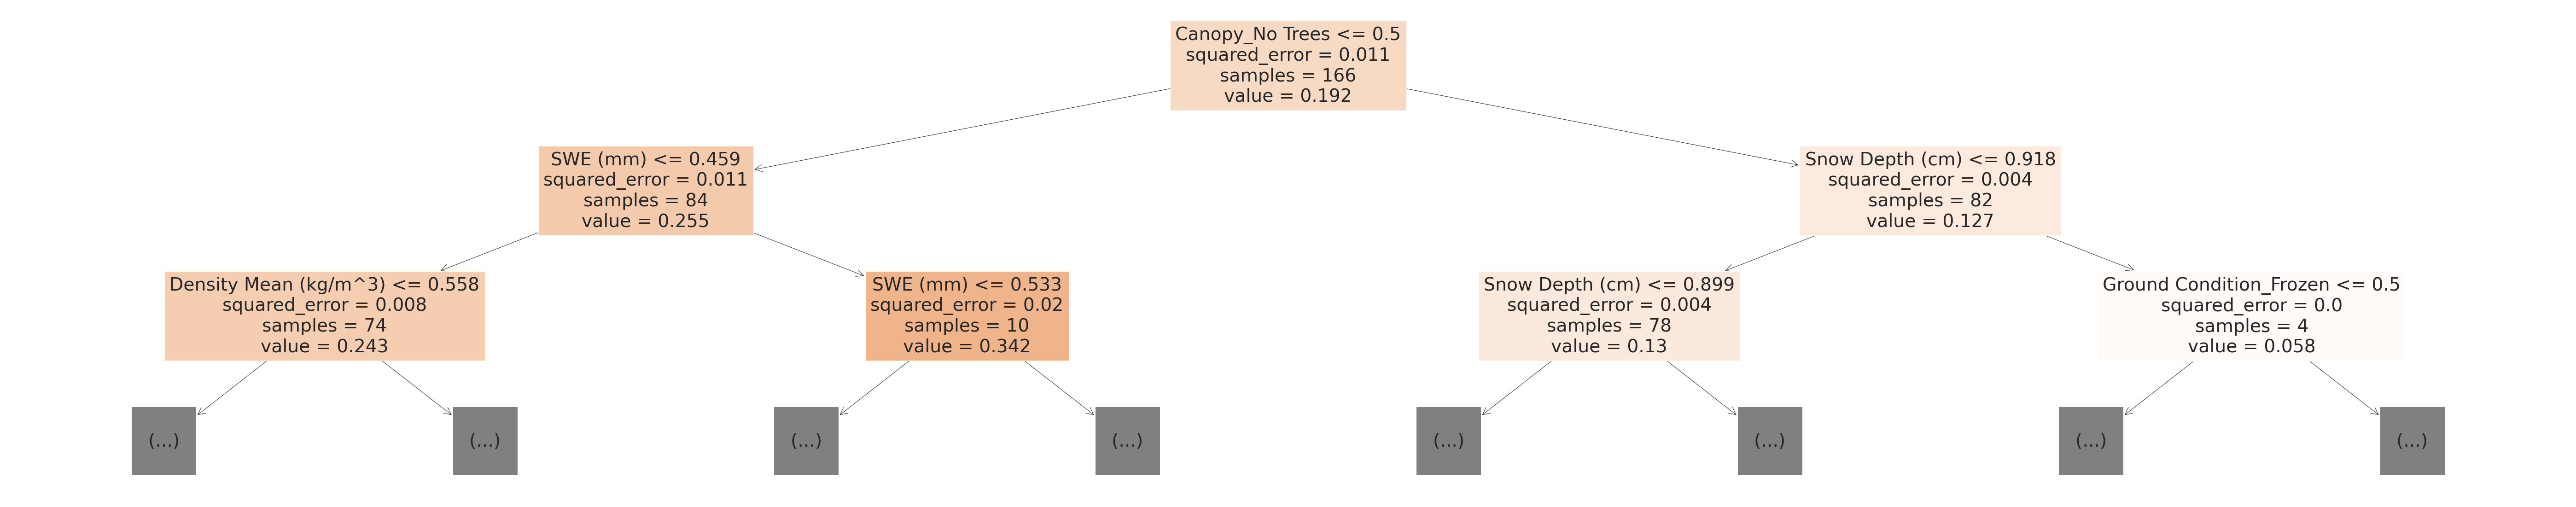

In [186]:
plt.figure(figsize=(100,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

Let's check the depth of the tree that was created.

In [187]:
model.tree_.max_depth

21

We can also display the tree as text, which can be easier to follow for deeper trees.

In [188]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Canopy_No Trees <= 0.50
|   |--- SWE (mm) <= 0.46
|   |   |--- Density Mean (kg/m^3) <= 0.56
|   |   |   |--- Ground Roughness_Smooth <= 0.50
|   |   |   |   |--- Canopy_Closed (>70%) <= 0.50
|   |   |   |   |   |--- Temp_mean <= 0.71
|   |   |   |   |   |   |--- SWE (mm) <= 0.22
|   |   |   |   |   |   |   |--- Temp_mean <= 0.53
|   |   |   |   |   |   |   |   |--- value: [0.31]
|   |   |   |   |   |   |   |--- Temp_mean >  0.53
|   |   |   |   |   |   |   |   |--- Density Mean (kg/m^3) <= 0.51
|   |   |   |   |   |   |   |   |   |--- Temp_mean <= 0.63
|   |   |   |   |   |   |   |   |   |   |--- value: [0.35]
|   |   |   |   |   |   |   |   |   |--- Temp_mean >  0.63
|   |   |   |   |   |   |   |   |   |   |--- value: [0.34]
|   |   |   |   |   |   |   |   |--- Density Mean (kg/m^3) >  0.51
|   |   |   |   |   |   |   |   |   |--- value: [0.34]
|   |   |   |   |   |   |--- SWE (mm) >  0.22
|   |   |   |   |   |   |   |--- value: [0.39]
|   |   |   |   |   |--- Temp_mean >  0.71


### Feature Importance

A decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [189]:
model.feature_importances_

array([9.53546245e-02, 1.36606220e-01, 2.38502533e-01, 6.34030040e-02,
       4.91900818e-03, 1.41552343e-02, 1.26993811e-03, 3.20182837e-04,
       2.01118989e-07, 3.38577628e-02, 1.71580493e-02, 3.58997153e-01,
       3.54560882e-02, 0.00000000e+00])

Let's turn this into a dataframe and visualize the most important features.

In [190]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [191]:
importance_df.head(10)

,feature,importance
11,Canopy_No Trees,0.358997
2,SWE (mm),0.238503
1,Snow Depth (cm),0.136606
0,Density Mean (kg/m^3),0.095355
3,Temp_mean,0.063403
12,Canopy_Open (20-70%),0.035456
9,Ground Roughness_Smooth,0.033858
10,Canopy_Closed (>70%),0.017158
5,Ground Condition_Moist,0.014155
4,Ground Condition_Frozen,0.004919


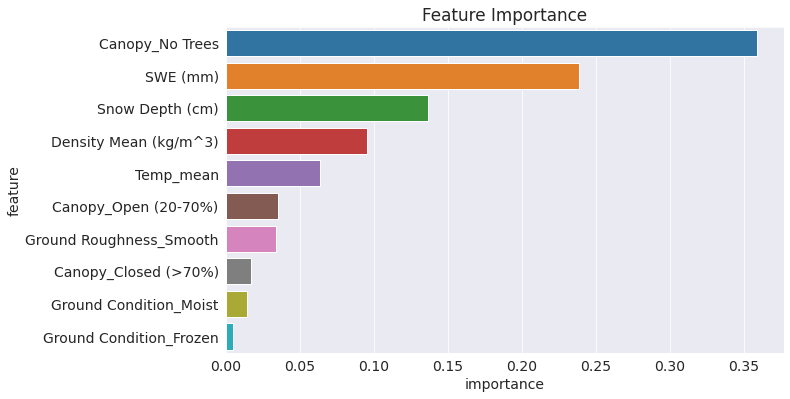

In [192]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was not that good. This phenomenon is called overfitting. Let's reduce overfitting. The process of reducing overfitting is known as _regularlization_.


The `DecisionTreeRegressor` accepts several arguments, some of which can be modified to reduce overfitting.

In [193]:
?DecisionTreeRegressor

Init signature:
DecisionTreeRegressor(
    *,
    criterion='squared_error',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree regressor.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"squared_error", "friedman_mse", "absolute_error",             "poisson"}, default="squared_error"
    The function to measure the quality of a split. Supported criteria
    are "squared_error" for the mean squared error, which is equal to
    variance reduction as feature selection criterion and minimizes the L2
    loss using the mean of each terminal node, "friedman_mse", which uses
    mean squared error with Friedman's improvement score for potential
    splits, "absolute_error" for the mean absolute error, which minimizes
    the L1 loss usi

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [194]:
model = DecisionTreeRegressor(max_depth=3, random_state=42)

In [195]:
model.fit(X_train, train_targets)

DecisionTreeRegressor(max_depth=3, random_state=42)

We can compute the accuracy of the model on the training and validation sets using `model.score`

In [196]:
model.score(X_train, train_targets)

0.5394809034662191

In [197]:
model.score(X_val, val_targets)

0.4125293780299405

Great, while the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly.

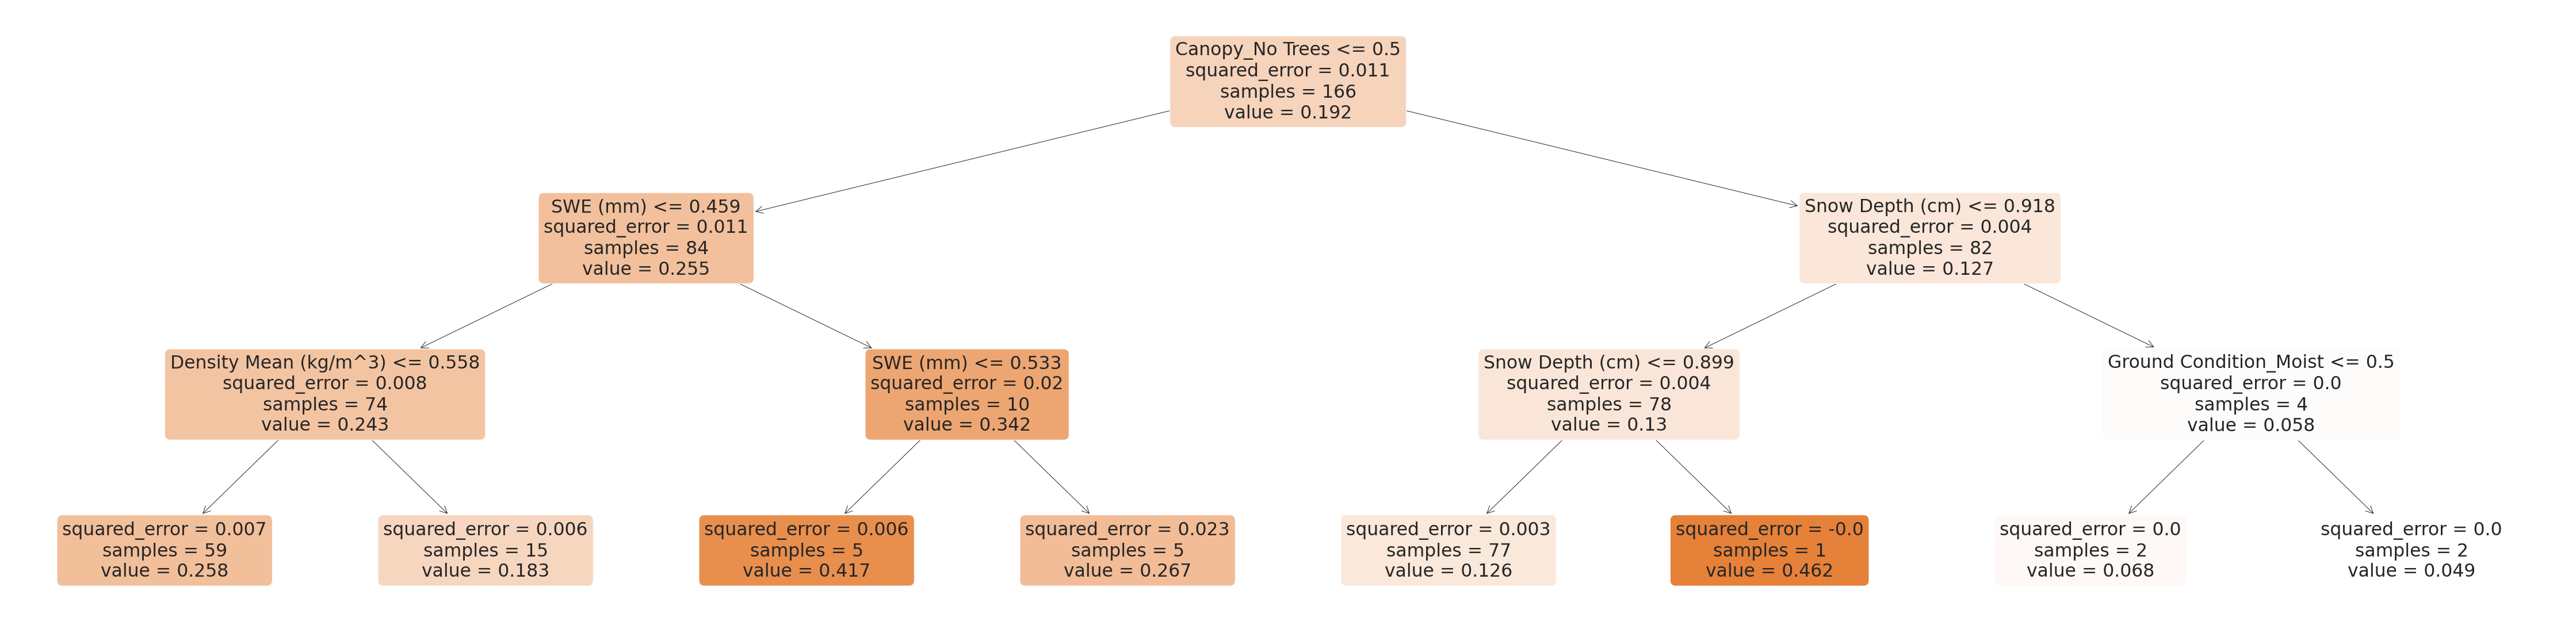

In [198]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True);

The uniqueness of the prediction depends on the depth of splitting. In other words, the leaf nodes and the depth of splitting are dependent

In [199]:
train_preds = model.predict(X_train)
np.unique(train_preds)

array([0.04907185, 0.06782968, 0.12609829, 0.18335028, 0.25827842,
       0.26730778, 0.41747955, 0.46206555])

In [200]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- Canopy_No Trees <= 0.50
|   |--- SWE (mm) <= 0.46
|   |   |--- Density Mean (kg/m^3) <= 0.56
|   |   |   |--- value: [0.26]
|   |   |--- Density Mean (kg/m^3) >  0.56
|   |   |   |--- value: [0.18]
|   |--- SWE (mm) >  0.46
|   |   |--- SWE (mm) <= 0.53
|   |   |   |--- value: [0.42]
|   |   |--- SWE (mm) >  0.53
|   |   |   |--- value: [0.27]
|--- Canopy_No Trees >  0.50
|   |--- Snow Depth (cm) <= 0.92
|   |   |--- Snow Depth (cm) <= 0.90
|   |   |   |--- value: [0.13]
|   |   |--- Snow Depth (cm) >  0.90
|   |   |   |--- value: [0.46]
|   |--- Snow Depth (cm) >  0.92
|   |   |--- Ground Condition_Moist <= 0.50
|   |   |   |--- value: [0.07]
|   |   |--- Ground Condition_Moist >  0.50
|   |   |   |--- value: [0.05]



Let's experiment with different depths using a helper function.

In [201]:
def max_depth_error(md):
    model = DecisionTreeRegressor(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = model.score(X_train, train_targets)
    val_acc = model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': 1- train_acc, 'Validation Error': 1- val_acc}

In [202]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 120 ms


In [203]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.641003,0.555111
1,2,0.584741,0.568941
2,3,0.460519,0.587471
3,4,0.338798,0.623617
4,5,0.242701,0.693855
5,6,0.181198,0.635235
6,7,0.120890,0.600812
7,8,0.086044,0.640915
8,9,0.054247,0.641013
9,10,0.033177,0.680401


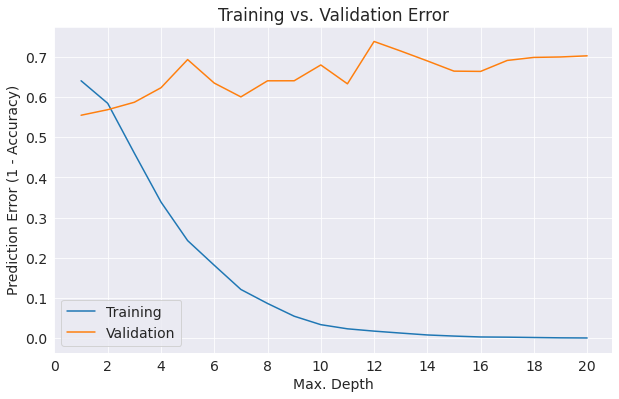

In [204]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

The plot above shows that optimal performance of the model is on the very simple model. Even for simple model, overfitting occurs. Decision Trees is perhaps too complex for the problem. This is because we have too small datasest to train the model. With a fewer or smaller number of datasets, it becomes easier for models to overfit a dataset even if the model is simpler.

The common pattern expected is below:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">





You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 3 results in the lowest validation error.

In [56]:
model = DecisionTreeRegressor(max_depth=3, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.4125293780299405

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [267]:
model = DecisionTreeRegressor(max_leaf_nodes= 15, random_state=42)
model.fit(X_train, train_targets)

DecisionTreeRegressor(max_leaf_nodes=15, random_state=42)

In [268]:
model.score(X_train, train_targets)

0.7087532132697139

In [269]:
model.score(X_val, val_targets)

0.511634993665203

In [270]:
model.tree_.max_depth

7

Let's define a helper function to test differebt params

In [236]:
def parameter(**params):
    #create the models
    model = DecisionTreeRegressor(random_state= 42, **params).fit(X_train, train_targets)
    #calculate the training and validation accuracy
    train_acc = model.score(X_train, train_targets)
    val_acc = model.score(X_val, val_targets)
    #put the model parameter, training error and validation error in a dataframe
    error = params
    error['Training Error'] = 1- train_acc
    error['Validation Error'] = 1- val_acc
    return error

In [252]:
def plot_error(errors_df):
    plt.figure()
    plt.plot(errors_df.iloc[:, 0], errors_df.iloc[:, 1])
    plt.plot(errors_df.iloc[:, 0], errors_df.iloc[:, 2])
    plt.title('Training vs. Validation Error')
    # plt.xticks(range(0,21, 2))
    plt.ylabel('Prediction Error (1 - Accuracy)')
    plt.legend(['Training', 'Validation'])

CPU times: user 368 ms, sys: 7.75 ms, total: 375 ms
Wall time: 402 ms


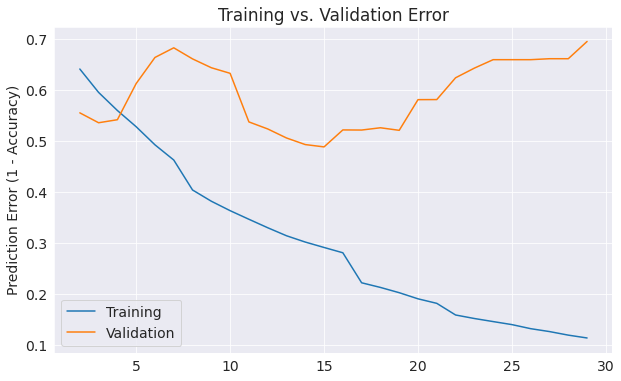

In [266]:
%%time
errors_mln = pd.DataFrame([parameter(max_leaf_nodes = val) for val in range(2, 30)])
plot_error(errors_mln)


15 looks to be the best

### `min_samples_split`

CPU times: user 179 ms, sys: 0 ns, total: 179 ms
Wall time: 177 ms


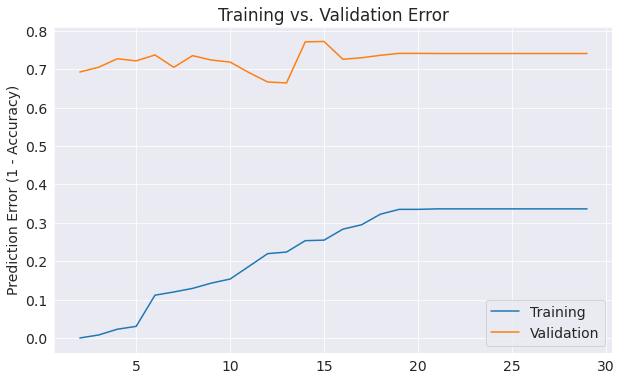

In [272]:
%%time
errors_mss = pd.DataFrame([parameter(min_samples_split = val) for val in range(2, 30)])
plot_error(errors_mss)

The default value of 2 looks good

### `min_samples_leaf`

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 174 ms


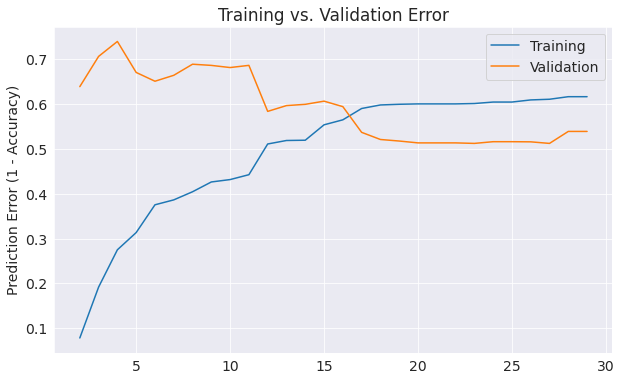

In [273]:
%%time
errors_msl = pd.DataFrame([parameter(min_samples_leaf = val) for val in range(2, 30)])
plot_error(errors_msl)

## Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd":

<img src="https://i.imgur.com/4Dg0XK4.png" width="480">

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestRegressor` class from `sklearn.ensemble`.

In [101]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [103]:
%%time
model.fit(X_train, train_targets)

CPU times: user 240 ms, sys: 29.5 ms, total: 269 ms
Wall time: 174 ms


RandomForestRegressor(n_jobs=-1, random_state=42)

In [104]:
model.score(X_train, train_targets)

0.8802288704670354

In [105]:
model.score(X_val, val_targets)

0.4374081363160457

Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can can access individual decision trees using `model.estimators_`

In [106]:
model.estimators_[0]

DecisionTreeRegressor(max_features=1.0, random_state=1608637542)

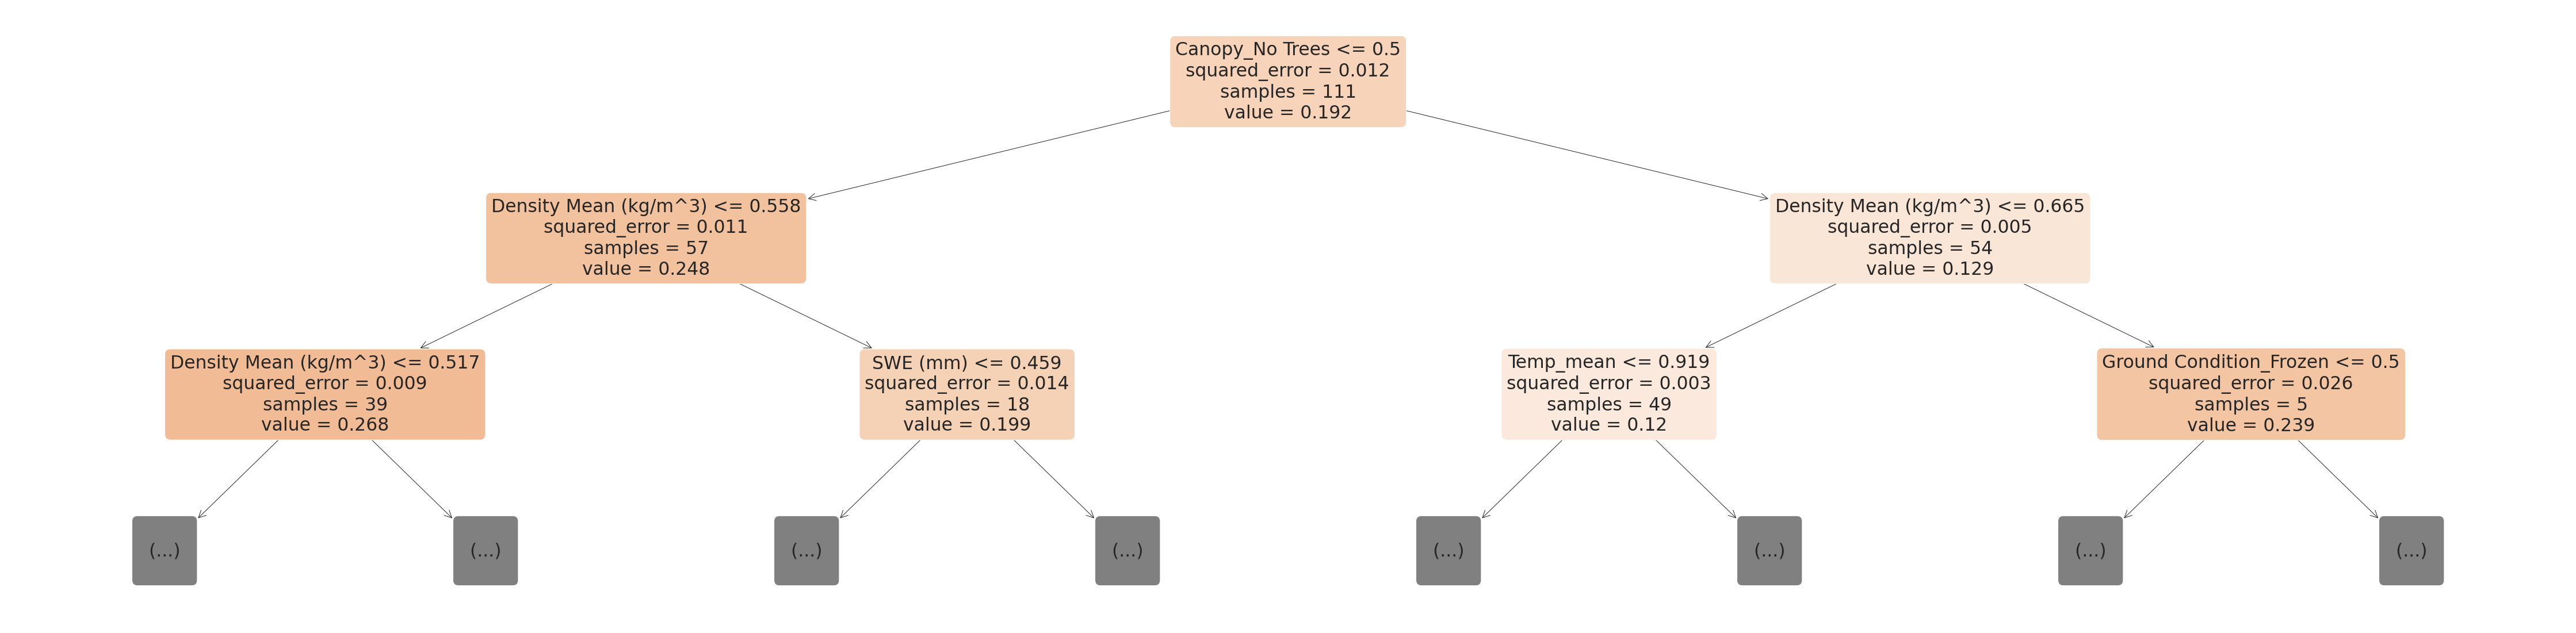

In [107]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True);

[Text(0.5, 0.875, 'Canopy_No Trees <= 0.5\nsquared_error = 0.011\nsamples = 105\nvalue = 0.199'),
 Text(0.25, 0.625, 'SWE (mm) <= 0.459\nsquared_error = 0.008\nsamples = 50\nvalue = 0.281'),
 Text(0.125, 0.375, 'Density Mean (kg/m^3) <= 0.538\nsquared_error = 0.007\nsamples = 43\nvalue = 0.266'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'Density Mean (kg/m^3) <= 0.615\nsquared_error = 0.002\nsamples = 7\nvalue = 0.386'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'SWE (mm) <= 0.737\nsquared_error = 0.003\nsamples = 55\nvalue = 0.128'),
 Text(0.625, 0.375, 'Snow Depth (cm) <= 0.46\nsquared_error = 0.003\nsamples = 48\nvalue = 0.137'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Ground Condition_Frozen <= 0.5\nsquared_error = 0.0\nsamples = 7\nvalue = 0.067'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  

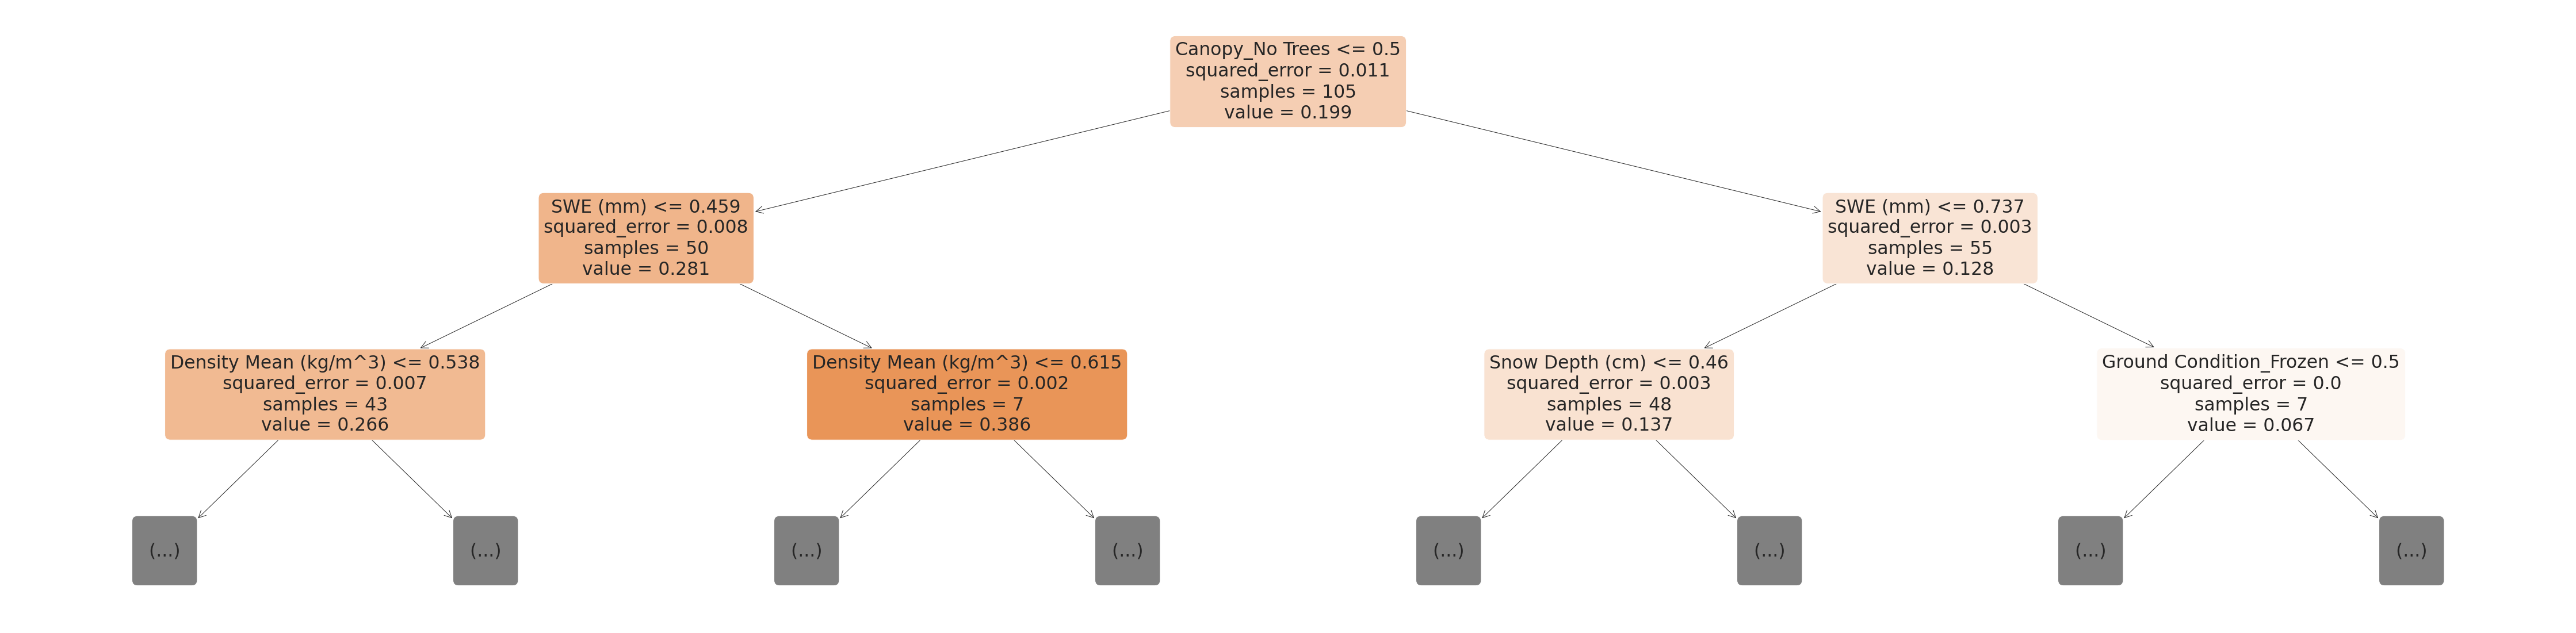

In [108]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[20], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True)

In [74]:
len(model.estimators_)

100

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees. Let's verify that most of the decision trees has lower accuracy than random forest.

In [134]:
print('Show list of tuples of depth and validation accuracy of each decision trees in the random forest')
[(model.estimators_[i].get_depth(), model.estimators_[i].score(X_val, val_targets) <= model.score(X_val, val_targets)) for i in range(100)]

Show list of tuples of depth and validation accuracy of each decision trees in the random forest


/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/naheemadebisi/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has f

[(19, True),
 (16, True),
 (14, True),
 (13, True),
 (15, True),
 (14, True),
 (13, True),
 (15, True),
 (12, True),
 (12, True),
 (17, True),
 (14, True),
 (14, True),
 (14, True),
 (17, True),
 (13, True),
 (16, True),
 (15, True),
 (16, True),
 (11, True),
 (15, True),
 (17, True),
 (11, True),
 (13, True),
 (14, True),
 (15, True),
 (14, True),
 (14, True),
 (15, True),
 (13, True),
 (16, True),
 (19, True),
 (14, True),
 (14, True),
 (14, True),
 (12, True),
 (12, True),
 (13, True),
 (16, True),
 (16, True),
 (13, True),
 (16, True),
 (14, True),
 (15, True),
 (12, True),
 (16, True),
 (16, True),
 (17, True),
 (16, True),
 (14, True),
 (14, True),
 (14, True),
 (15, True),
 (13, True),
 (14, True),
 (14, True),
 (13, True),
 (16, True),
 (13, True),
 (16, True),
 (13, True),
 (14, True),
 (12, True),
 (16, True),
 (13, True),
 (12, True),
 (12, True),
 (13, True),
 (15, True),
 (14, True),
 (15, True),
 (14, True),
 (15, True),
 (13, True),
 (15, True),
 (15, True),
 (15, True),

In [120]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [121]:
importance_df.head(10)

,feature,importance
11,Canopy_No Trees,0.362837
2,SWE (mm),0.170520
1,Snow Depth (cm),0.135389
0,Density Mean (kg/m^3),0.133417
3,Temp_mean,0.117751
9,Ground Roughness_Smooth,0.021104
4,Ground Condition_Frozen,0.011611
12,Canopy_Open (20-70%),0.010959
7,Ground Roughness_Rough,0.010573
5,Ground Condition_Moist,0.009554


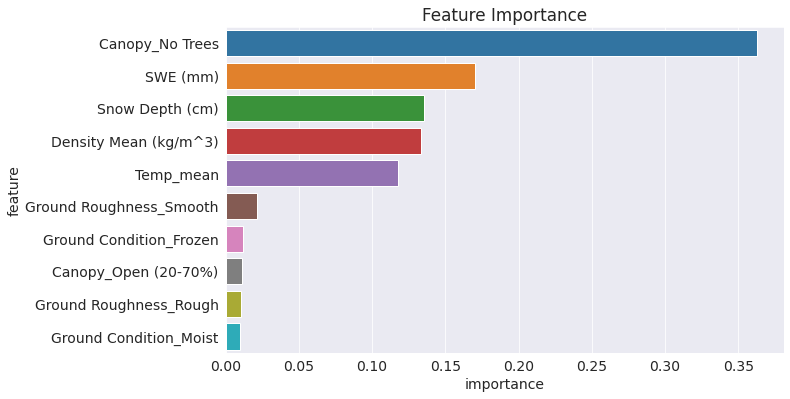

In [122]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [79]:
?RandomForestRegressor

Init signature:
RandomForestRegressor(
    n_estimators=100,
    *,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest regressor.

A random forest is a meta estimator that fits a number of classifying
decision trees on various sub-samples of the dataset and uses averaging
to improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.

    .. versioncha

Let's create a base model with which we can compare models with tuned hyperparameters.

In [135]:
base_model = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train, train_targets)

In [136]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [137]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.8802288704670354, 0.4374081363160457)

We can use this as a benchmark for hyperparmeter tuning.

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


**5 estimators**

In [154]:
model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=5)
model.fit(X_train, train_targets)
print(f"Trainining and Validation score: {model.score(X_train, train_targets), model.score(X_val, val_targets)}")
print(f"Trainining and Validation score on base model: {base_accs}")

Trainining and Validation score: (0.8709438487793554, 0.48086627091480316)
Trainining and Validation score on base model: (0.8802288704670354, 0.4374081363160457)


**10 estimators**

In [155]:
model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=10)
model.fit(X_train, train_targets)
print(f"Trainining and Validation score: {model.score(X_train, train_targets), model.score(X_val, val_targets)}")
print(f"Trainining and Validation score on base model: {base_accs}")

Trainining and Validation score: (0.8800793699878646, 0.4584773309664735)
Trainining and Validation score on base model: (0.8802288704670354, 0.4374081363160457)


**200 estimators**

In [156]:
model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=200)
model.fit(X_train, train_targets)
print(f"Trainining and Validation score: {model.score(X_train, train_targets), model.score(X_val, val_targets)}")
print(f"Trainining and Validation score on base model: {base_accs}")

Trainining and Validation score: (0.8802627267227203, 0.44319242164508754)
Trainining and Validation score on base model: (0.8802288704670354, 0.4374081363160457)


It looks like the accuracy begins to degrade with more estimators. Vary the value of `n_estimators` and plot the graph between training error and validation error. What is the optimal value of `n_estimators`?

In [157]:
def n_estimate_error(ne):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=ne)
    model.fit(X_train, train_targets)
    train_acc = model.score(X_train, train_targets)
    val_acc = model.score(X_val, val_targets)
    return {'Number of Estimator': ne, 'Training Error': 1- train_acc, 'Validation Error': 1- val_acc}

In [161]:
%%time
errors_df = pd.DataFrame([n_estimate_error(ne) for ne in range(1, 110, 5)])

CPU times: user 2.91 s, sys: 615 ms, total: 3.52 s
Wall time: 2.34 s


In [162]:
errors_df

,Number of Estimator,Training Error,Validation Error
0,1,0.387394,1.041861
1,6,0.135881,0.500969
2,11,0.117010,0.558472
3,16,0.115143,0.581689
4,21,0.112633,0.577216
5,26,0.115206,0.584204
6,31,0.116489,0.569300
7,36,0.114579,0.572758
8,41,0.111848,0.570955
9,46,0.115651,0.557752


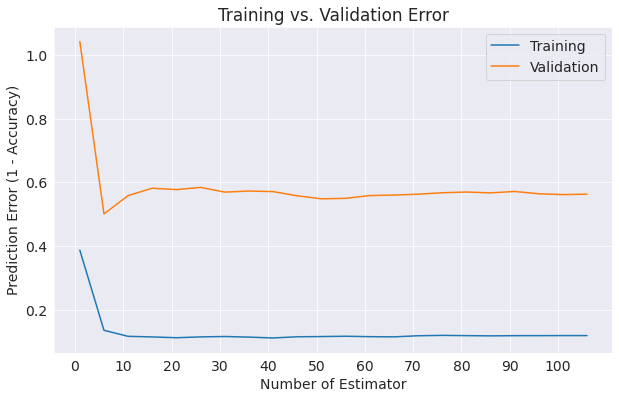

In [165]:
plt.figure()
plt.plot(errors_df['Number of Estimator'], errors_df['Training Error'])
plt.plot(errors_df['Number of Estimator'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0, 110, 10))
plt.xlabel('Number of Estimator')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

Based on the graph above, it is evident that the n_estimate of 5 gives the best prediction results.

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [325]:
model = RandomForestRegressor(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=7)
model.fit(X_train, train_targets)

RandomForestRegressor(n_estimators=7, n_jobs=-1, random_state=42)

In [326]:
print(f"Trainining and Validation score: {model.score(X_train, train_targets), model.score(X_val, val_targets)}")
print(f"Trainining and Validation score on base model: {base_accs}")

Trainining and Validation score: (0.857580520055504, 0.4935625330983566)
Trainining and Validation score on base model: (0.8802288704670354, 0.4374081363160457)


max_leaf_nodes = 15 give val accuracy of about 0.5 on DT.

In [339]:
model = RandomForestRegressor(n_jobs=-1, 
                               random_state=42, 
                               n_estimators= 10,
                               max_leaf_nodes = 15)
model.fit(X_train, train_targets)

RandomForestRegressor(max_leaf_nodes=15, n_estimators=10, n_jobs=-1,
                      random_state=42)

In [340]:
print(f"Trainining and Validation score: {model.score(X_train, train_targets), model.score(X_val, val_targets)}")
print(f"Trainining and Validation score on base model: {base_accs}")

Trainining and Validation score: (0.7356976792594743, 0.4561777476010256)
Trainining and Validation score on base model: (0.8802288704670354, 0.4374081363160457)
